In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import scipy
import cv2
from PIL import Image

In [2]:
model = tf.keras.models.load_model(r"model\finalModelWaterPollution.h5")

In [5]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1]),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [8]:
model2.compile(optimizer='sgd', loss='mean_squared_error')
model2.fit(x=[-1, 0, 1], y=[-3, -1, 1], epochs=5)

Epoch 1/5

1/1 [==============================] - 1s 1s/step - loss: 5.3371
Epoch 2/5
1/1 [==============================] - 0s 11ms/step - loss: 4.9424
Epoch 3/5
1/1 [==============================] - 0s 8ms/step - loss: 4.6048
Epoch 4/5
1/1 [==============================] - 0s 7ms/step - loss: 4.3146
Epoch 5/5
1/1 [==============================] - 0s 9ms/step - loss: 4.0609


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\s9554\AppData\Local\Temp\tmpcp14x8gw\assets


INFO:tensorflow:Assets written to: C:\Users\s9554\AppData\Local\Temp\tmpcp14x8gw\assets


In [10]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model(r"model\finalModelWaterPollution.h5") # path to the SavedModel directory
tflite_model = converter.convert()

OSError: SavedModel file does not exist at: model\finalModelWaterPollution.h5\{saved_model.pbtxt|saved_model.pb}

In [3]:
def predict(img_path):
    img = load_img(img_path,target_size = (224,224))
    img2 = img_to_array(img)
    x = img_to_array(img) 
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    return model.predict(x)

In [4]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [5]:
def heatMap(img_path):
    last_layer_weights = model.layers[-1].get_weights()[0]
    img = load_img(img_path,target_size = (224,224))
    img_array = img_to_array(img)
    x = img_to_array(img) 
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    conv_out ,pred_class = model.predict(x)
    pred_class = np.argmax(pred_class)
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    last_conv_output = np.squeeze(conv_out)
    h = int(img_array.shape[0]/last_conv_output.shape[0])
    w = int(img_array.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    heat_map = np.dot(upsampled_last_conv_output.reshape((224 * 224, 2048)),
                     last_layer_weights_for_pred).reshape(img_array.shape[0],img_array.shape[1])
    normalized_heat_map = (heat_map - np.min(heat_map)) / (np.max(heat_map) - np.min(heat_map))
    heatmap_jet = cv2.applyColorMap(np.uint8(255 * normalized_heat_map), cv2.COLORMAP_JET)
    alpha = 0.5
    heatmap_rgba = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGBA)
    heatmap_alpha = heatmap_rgba[:, :, 3]
    blended_img = cv2.addWeighted(img_array.astype(np.uint8), 1 - alpha, heatmap_rgba[:, :, :3], alpha, 0)
    plt.imshow(blended_img)
    plt.show()
    return blended_img

1/1 [==============================] - 2s 2s/step


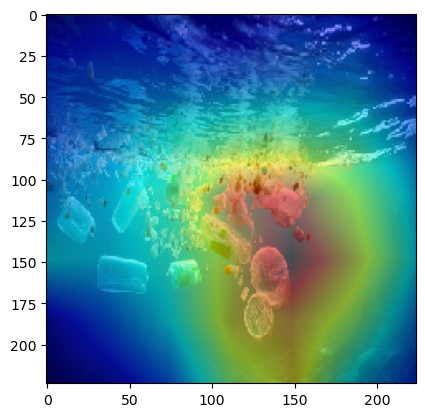

In [6]:
img = heatMap(r"testTwo.jpg")

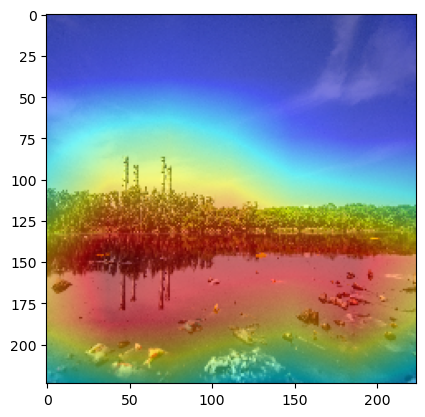

In [270]:
plt.imshow(img)